# Imports

In [ ]:
!pip install holidays
!pip install pybats
!pip install catboost

In [ ]:
import os
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import holidays

import catboost as cb

import warnings
warnings.filterwarnings('ignore')

# Reading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Project2_data')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def read_data(filename):
    dateparse = lambda x: pd.to_datetime(x.split()[0],
                                         format='%Y-%m-%d').strtime('%d/%m/%Y') if type(x) == 'str' else x
    kind = filename.split('.')[1]
    if kind == 'csv':
        df = pd.read_csv(filename, index_col=[0], parse_dates=[0], date_parser=dateparse, dtype='float')
        return df.dropna(axis=0, how='all')
    if kind == 'xlsx':
        df = pd.read_excel(filename, engine='openpyxl', index_col=[0], parse_dates=[0],
                             date_parser=dateparse)
        for col in df.columns:
            df[col] = df[col].astype(np.float64)
        return df.dropna(axis=1, how='all')

In [ ]:
from pandas._libs import index
datafile = 'Project 2_2022.csv'
df = read_data(datafile)
df['workday'] = (df['Income'] != 0) & (df['Outcome'] != 0) & (~df.index.day_of_week.isin({5, 6}))

ru_holidays = holidays.RU(years=np.arange(2017, 2022))
workday = ~(df.index.isin(ru_holidays)) & ~(df.index.day_of_week.isin({5, 6}))
df['day'] = df.index.day_name()
df['month'] = df.index.month_name()
df['year'] = df.index.year
df.tail(10)


,Income,Outcome,Balance,workday,day,month,year
Date,,,,,,,
2021-03-22,1.962,2.778,-0.810884,True,Monday,March,2021
2021-03-23,2.489,2.396,0.098041,True,Tuesday,March,2021
2021-03-24,1.936,2.528,-0.587778,True,Wednesday,March,2021
2021-03-25,2.304,3.173,-0.869810,True,Thursday,March,2021
2021-03-26,2.173,4.687,-2.510000,True,Friday,March,2021
2021-03-27,0.000,0.000,0.000000,False,Saturday,March,2021
2021-03-28,0.000,0.000,0.000000,False,Sunday,March,2021
2021-03-29,2.357,3.371,-1.017679,True,Monday,March,2021
2021-03-30,2.317,2.568,-0.259687,True,Tuesday,March,2021


## Подсчёт чистого сальдо

UPD задание было неверно понято и, вероятно, это нам не нужно

In [ ]:
# wd = (df['Income'] != 0) & (df['Outcome'] != 0)

# num_weekends_before=[0] * len(wd)

# k = 1
# for i, working in enumerate(wd):
#     if not working:
#         k += 1
#     else:
#         num_weekends_before[i] = k
#         k = 1
# df['weekends_before'] = num_weekends_before
# df.head(10)

In [ ]:
# # =IF(AND(B3=0,C3=0),0,IF(D3<0,D3*(14%+1%),IF(D3>0,D3*(14%-0.9%)*0.5+D3*(14%+0.5%)*0.5,0)))
# def cf_management(income, outcome, balance):
#     if income + outcome == 0:
#         return 0
#     if balance < 0:
#         return balance * (0.14 + 0.01)
#     if balance > 0:
#         return balance * (0.14 - 0.009) * 0.5 + balance * (0.14 + 0.005) * 0.5
#     return 0

# df['cf_manag'] = df.apply(lambda x: cf_management(x.Income, x.Outcome, x.Balance), axis=1)
# df = df[df['workday']]
# df['prev_balance'] = df['Balance'].shift(1)
# df['prev_cf_manag'] = df['cf_manag'].shift(1)
# Income w/ overnight profit
# =IF(AND(B4=0,C4=0),0,IF(prev_cf<0,B4,B4-SUM(D3:E3)))
# cf_neg = 
# df['pure_income'] = df['Income'] * (df['prev_cf_manag'] < 0) + (df['Income'] - df['prev_balance'] - df['weekends_before'] * df['prev_cf_manag']) * (df['prev_cf_manag'] >= 0)
# df['pure_outcome'] = df['Outcome'] * (df['prev_cf_manag'] > 0) + (df['Outcome'] + df['prev_balance'] + df['weekends_before'] * df['prev_cf_manag']) * (df['prev_cf_manag'] <= 0)
# df['pure_balance'] = df['pure_income'] - df['pure_outcome']
# df.head(40)

# Data visualisation 

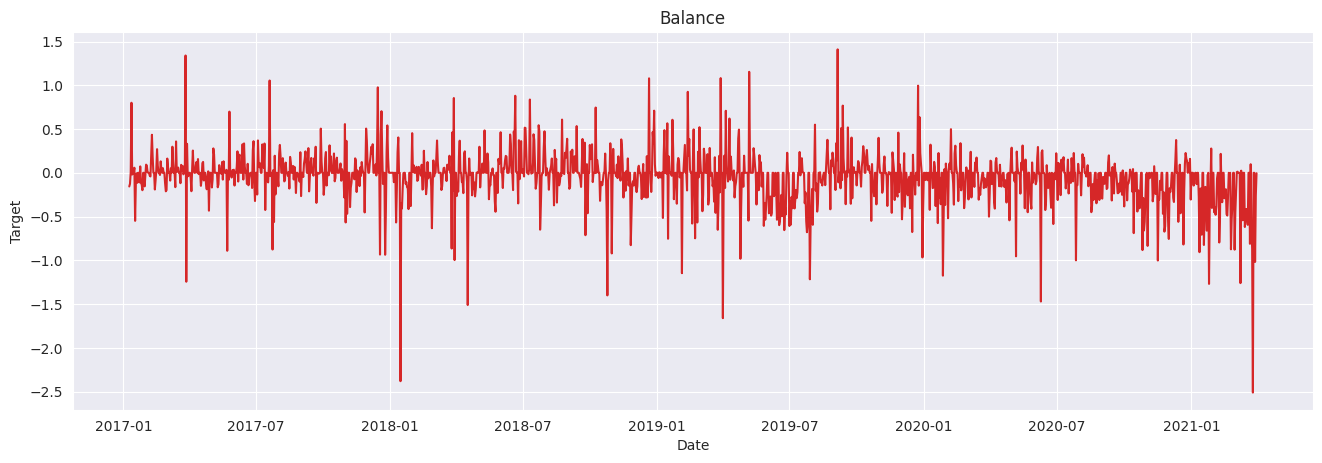

In [ ]:
def plot_df(df, col, title="", xlabel='Date', ylabel='Target', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(df.index, df[col], color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, col='Balance', title='Balance') 

Чтобы понять как задействовать налоговые дни, посмотрим на график Income и Outcome в том месяце, когда нужно сдавать поквартальную отчётность. Может быть мы найдём тут какую-то зависимость

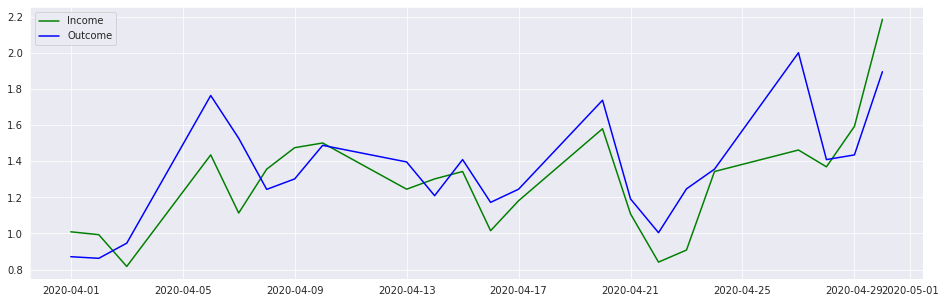

In [ ]:
fltr = (df['month'] == 'April') & (df['year'] == 2020) & df['workday'] 
plt.figure(figsize=(16,5))
df2 = df[fltr].copy()
plt.plot(df2.index, df2['Income'], c='g', label='Income')
plt.plot(df2.index, df2['Outcome'], c='b', label='Outcome')
plt.legend()
plt.show()

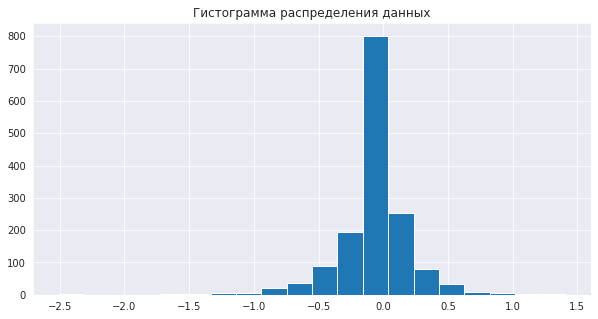

In [ ]:
plt.title('Гистограмма распределения данных')

series = df.Balance
series.hist(bins=20, figsize = (10,5))
plt.show()

Визуально данные походят на нормально распределённые, но, похоже, есть достаточно большие выбросы. Построим box-plot


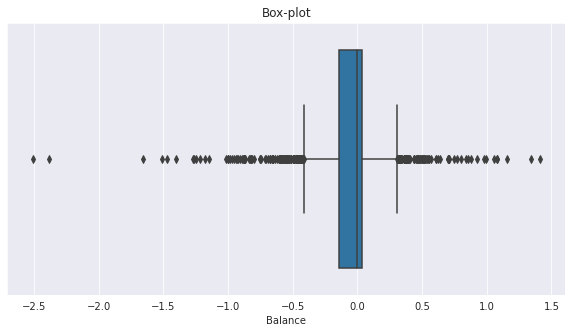

In [ ]:
fig = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(x=series,whis=1.5)
ax.set_title('Box-plot')
plt.show()

In [ ]:
sigma = series.std()
prc = lambda x: 100 * sum(np.abs(np.array(series) - series.mean()) > x * sigma) / len(series)
print("примерно %.1f процентов данных выходят за удвоенную дисперсию" %prc(2))
print("а также  %.1f процентов данных выходят за утроенную дисперсию" %prc(3))

примерно 5.1 процентов данных выходят за удвоенную дисперсию
а также  2.1 процентов данных выходят за утроенную дисперсию


In [ ]:
dates_outl[0]

numpy.datetime64('2017-01-12T00:00:00.000000000')

In [ ]:
dates_outl = series[np.abs(np.array(series) - series.mean()) > sigma].index
for i in range(len(dates_outl) - 1):
    print(dates_outl[i + 1] - dates_outl[i])

5 days 00:00:00
23 days 00:00:00
7 days 00:00:00
21 days 00:00:00
5 days 00:00:00
13 days 00:00:00
1 days 00:00:00
1 days 00:00:00
8 days 00:00:00
22 days 00:00:00
6 days 00:00:00
19 days 00:00:00
3 days 00:00:00
11 days 00:00:00
7 days 00:00:00
2 days 00:00:00
12 days 00:00:00
1 days 00:00:00
6 days 00:00:00
6 days 00:00:00
3 days 00:00:00
1 days 00:00:00
6 days 00:00:00
4 days 00:00:00
2 days 00:00:00
8 days 00:00:00
35 days 00:00:00
4 days 00:00:00
10 days 00:00:00
1 days 00:00:00
6 days 00:00:00
12 days 00:00:00
21 days 00:00:00
1 days 00:00:00
1 days 00:00:00
1 days 00:00:00
4 days 00:00:00
20 days 00:00:00
2 days 00:00:00
1 days 00:00:00
6 days 00:00:00
2 days 00:00:00
6 days 00:00:00
1 days 00:00:00
3 days 00:00:00
1 days 00:00:00
1 days 00:00:00
5 days 00:00:00
1 days 00:00:00
2 days 00:00:00
12 days 00:00:00
3 days 00:00:00
3 days 00:00:00
1 days 00:00:00
1 days 00:00:00
9 days 00:00:00
3 days 00:00:00
2 days 00:00:00
16 days 00:00:00
11 days 00:00:00
7 days 00:00:00
20 days 0

In [ ]:
def plot_ACF_and_PACF(df):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df,lags=150, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df,lags=150, ax=ax2)

def seasonal_decompose(series, season=7, model = 'additive'):
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompfreq = season
    plt.rcParams.update({'figure.figsize': (20,10)})
    decomposition = seasonal_decompose(series,
                                     freq=decompfreq, model=model)
    fig = decomposition.plot()
    plt.savefig('stochastic_decomposition.png') 
    plt.show()


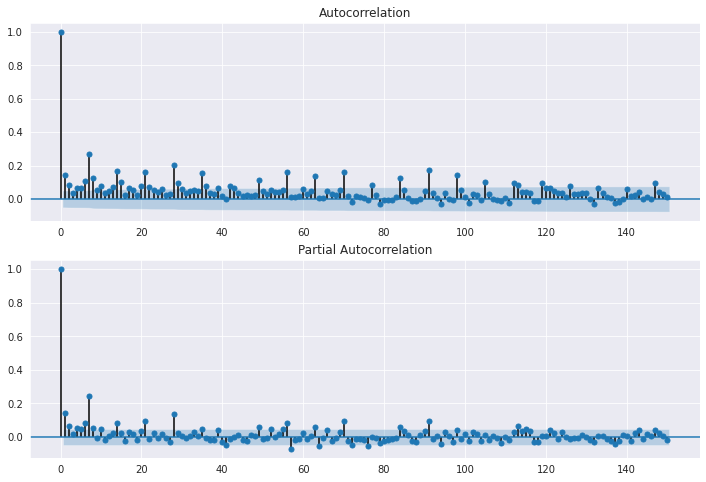

In [ ]:
plot_ACF_and_PACF(df[['Balance']])

По графикам видно, что корреляция с каждым 7м лагом высокая. Для линейной модели хорошо будет выбрать лаги с 1го до 28го. Выбираем до 28го, так как это окно почти в месяц, и, кроме того, корреляция и частиная коррелляция с 28м лагом высокая

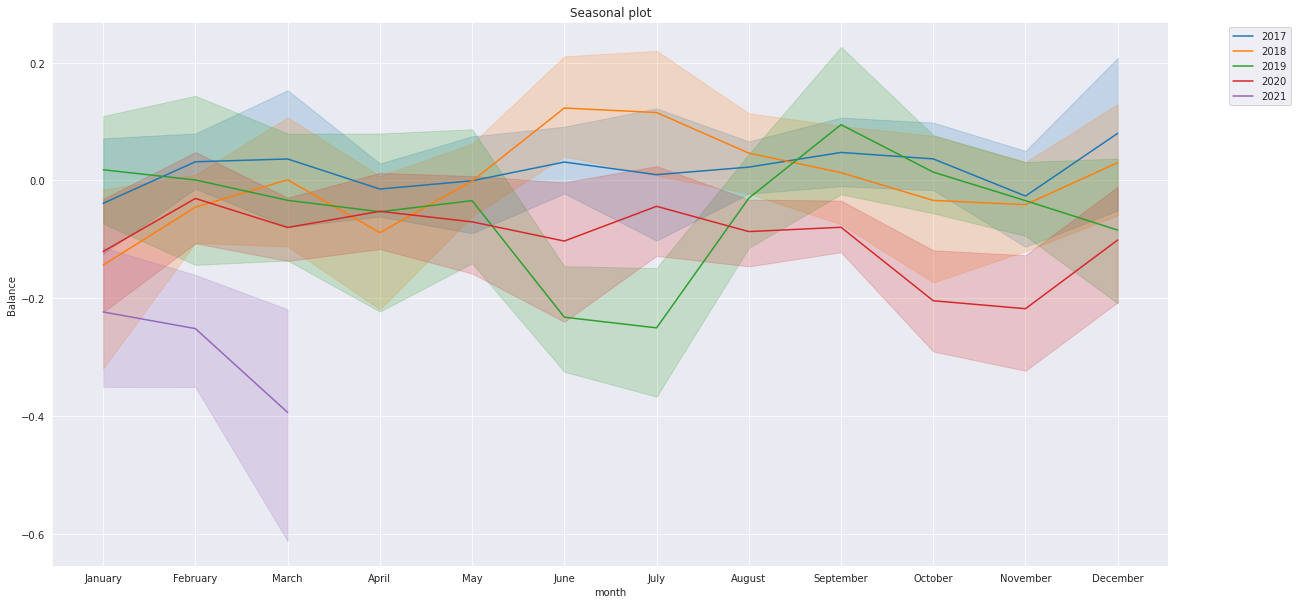

In [ ]:
plt.rcParams.update({'figure.figsize': (20,10)})
sns.lineplot(data=df, 
             x='month', 
             y='Balance', 
             hue='year', 
             legend='full', palette=color[:5])
plt.title('Seasonal plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

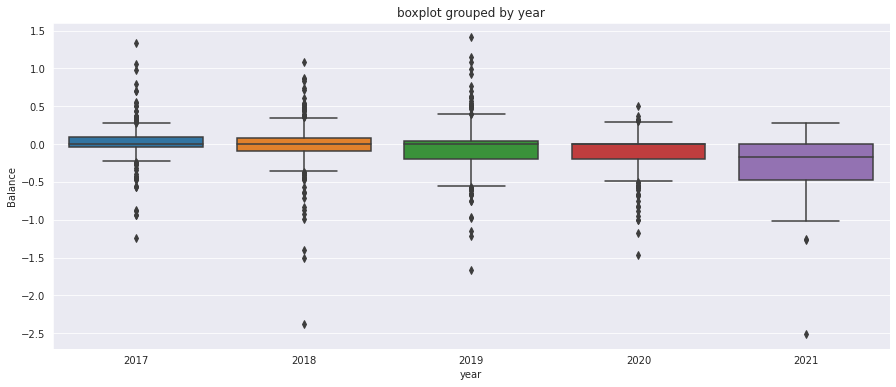

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title('boxplot grouped by year')
sns.boxplot(data = df, x ='year', y='Balance', ax=ax)
plt.show()

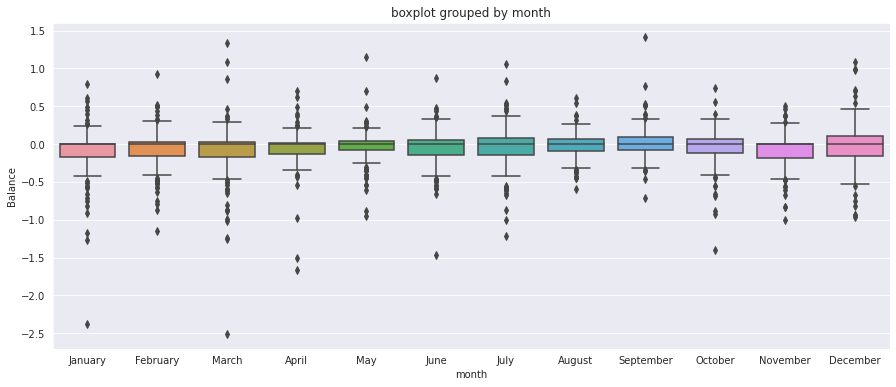

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title('boxplot grouped by month')
sns.boxplot(data = df, x ='month', y='Balance', ax=ax)
plt.show()

Явного монотонного изменения статистик (медианы, разброса и т.д.) по месяцам не наблюдается. Много выбросов

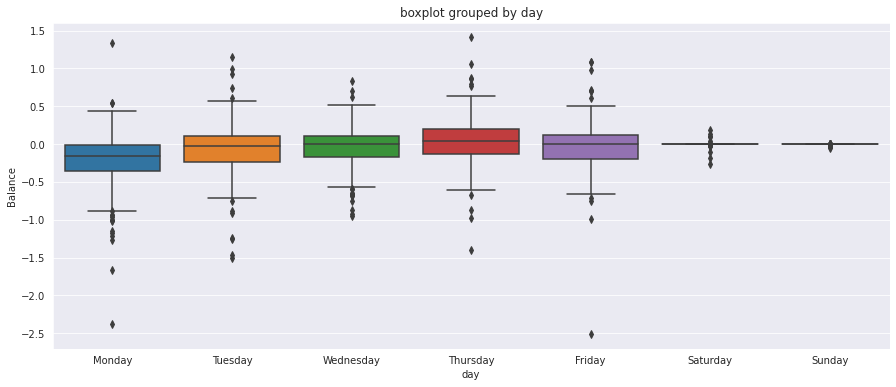

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title('boxplot grouped by day')
sns.boxplot(data = df, x ='day', y='Balance', ax=ax)
plt.show()

Можно заметить зависимость статистик от дней недели. Закодированный средним или медианой день недели подойдёт в качестве фичи.

# Feature extraction

Нам нужно предсказать сальдо на следующий день. Поэтому можем выбирать лаги, начиная с первого. В предыдущем анализе мы показали, что имеет смысл выбирать лаг по 28 включительно

In [ ]:
NUM_PREV_DAYS = 28

data = pd.DataFrame(df.Balance.copy())
data.columns = ["y"]
for i in range(1, 28 + 1):
    data["lag_{}".format(i)] = data.y.shift(i)
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-27,0.000000,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,0.000000,0.000000,-0.594002,-0.473214,...,-0.000016,0.000000,0.000000,0.013004,0.008114,-0.231965,-0.448464,-0.877702,0.000000,0.000000
2021-03-28,0.000000,0.000000,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,0.000000,0.000000,-0.594002,...,-1.259843,-0.000016,0.000000,0.000000,0.013004,0.008114,-0.231965,-0.448464,-0.877702,0.000000
2021-03-29,-1.017679,0.000000,0.000000,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,0.000000,0.000000,...,0.024578,-1.259843,-0.000016,0.000000,0.000000,0.013004,0.008114,-0.231965,-0.448464,-0.877702
2021-03-30,-0.259687,-1.017679,0.000000,0.000000,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,0.000000,...,-0.318210,0.024578,-1.259843,-0.000016,0.000000,0.000000,0.013004,0.008114,-0.231965,-0.448464
2021-03-31,-0.004878,-0.259687,-1.017679,0.000000,0.000000,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,...,-0.541814,-0.318210,0.024578,-1.259843,-0.000016,0.000000,0.000000,0.013004,0.008114,-0.231965


Ещё нам понадобится бинарный признак workday.
Кроме того, закодируем день недели, месяц и год средним значением 

In [ ]:
data['workday'] = df['workday']

def encode_catigorical(col_name, df=df):
    d = df.groupby(col_name)['Balance'].mean()
    return df[col_name].map(d)

for c in ['day', 'month', 'year']:
    data[c] = encode_catigorical(c)
data.head(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,workday,day,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,-0.155904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.228368,-0.105009,0.019244
2017-01-10,-0.125572,-0.155904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.061925,-0.105009,0.019244
2017-01-11,0.007767,-0.125572,-0.155904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.046709,-0.105009,0.019244
2017-01-12,0.800391,0.007767,-0.125572,-0.155904,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,0.035342,-0.105009,0.019244
2017-01-13,-0.019721,0.800391,0.007767,-0.125572,-0.155904,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.038566,-0.105009,0.019244
2017-01-14,0.000000,-0.019721,0.800391,0.007767,-0.125572,-0.155904,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-0.000426,-0.105009,0.019244
2017-01-15,0.000000,0.000000,-0.019721,0.800391,0.007767,-0.125572,-0.155904,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-0.000460,-0.105009,0.019244


Позже в pipline в классе feature builder ещё появятся лаги по переменным Inсome, Outcome, а также скользящие средние с окнами в 7, 30, 90 и 365 

## Макроэкономические признаки

В качестве возможных признаков модели рассмотрим в первую очередь макроэкономические показатели. 

Поскольку данные представляют из себя сальдо притоков и оттоков за день, с которого также, судя по имеющейся у нас информации, списыватеся какой-то налог, а именно налог на прибыль (судя по скачкам ближе к 28 числу каждого месяца), логично предположить, что данные представляют из себя агрегированные расчетные счета компаний.

Соответственно, логично будет выбрать показатели, которые наиболее тесно связанны с прогнозируемой прибылью/убытками компаний. В качестве таких показателй я выбрал:
- Ключевую ставку;
- Валютную пару RUBUSD;
- Наиболее важные для казначейства ставки MosPrime, RUONIA (которые в себе уже отражают инфляцию, ключевую ставку и опосредованно курс, так что стоит ждать высоку корреляцию выбранных показателей);
- Ставки группы MIACR (только овернайт);
- Обратную сторону в виде сальдо операций Банка России по предоставлению/абсорбированию ликвидности;
- Агрегированный индекс PMI России (можно взять и RSBI, если найти где ПСБ нормально данные разместило) отражающий деловую активность;
- И бонды на разный срок.

In [ ]:
def corr_heatmap(df):
    plt.figure(figsize=(16, 16))
    corrmat = df.corr()
    sns.heatmap(corrmat, mask=np.zeros_like(corrmat, dtype=np.bool),
                square=True, annot=True,
                cmap=sns.diverging_palette(220, 10, as_cmap=True))
    plt.show()

df_full = df.copy()
for filename in os.listdir():
    if '.' not in filename:
        continue 
    name, kind = filename.split('.')
    if kind == 'xlsx':
        df2 = read_data(filename)
        try:
            # if filename[:3] == 'Mos':
            #     print(df2.head())
            df_full = df_full.join(df2,how='left')
            # df_full.fillna(method='ffill', inplace=True)
        except:
            print("Failed to open", name)
df_full.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

In [ ]:
cols = list(df_full.columns)
cols1 = cols[:3] + cols[3: 19]
cols2 = cols[:3] + cols[19:]

### Фильтрационный отбор макроэкономических признаков

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


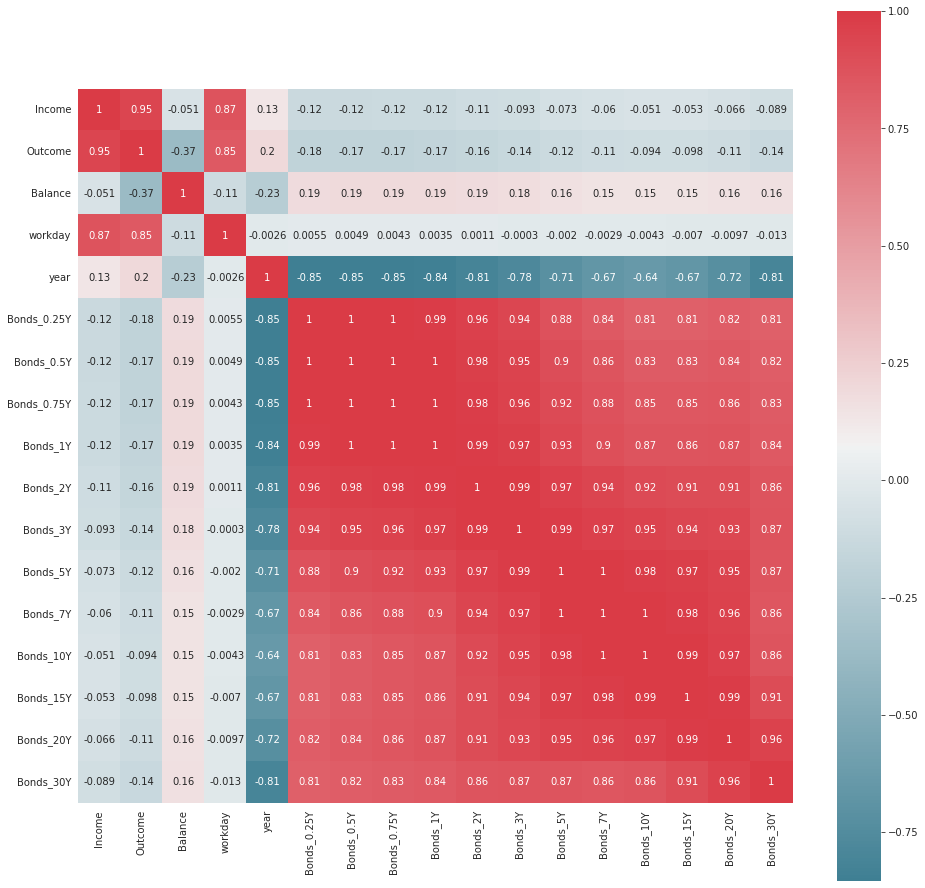

In [ ]:
corr_heatmap(df_full[cols1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


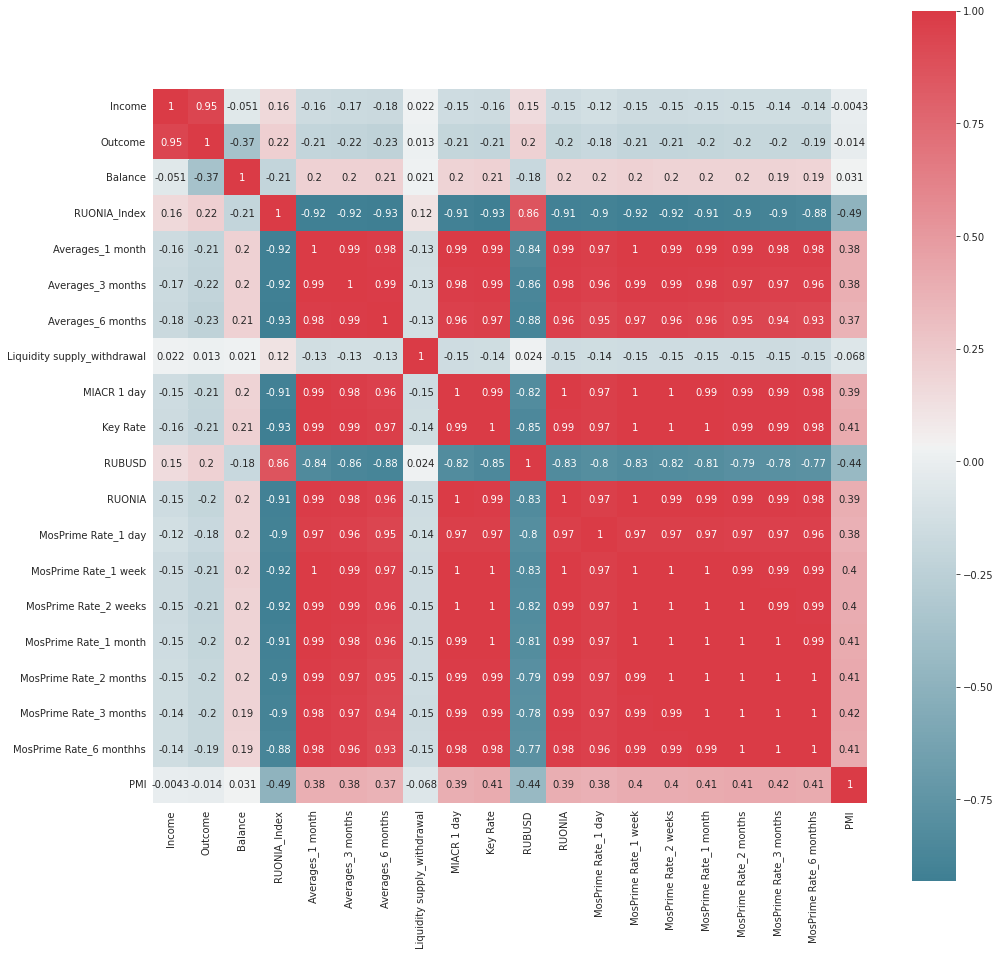

In [ ]:
corr_heatmap(df_full[cols2])

Поскольку, как и предполагалось, показатели имеют достаточно выскоую корреляцию между собой и +/- схожую корреляцию к имеющимся данным, джаджментали мной был выбран ряд показателей

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


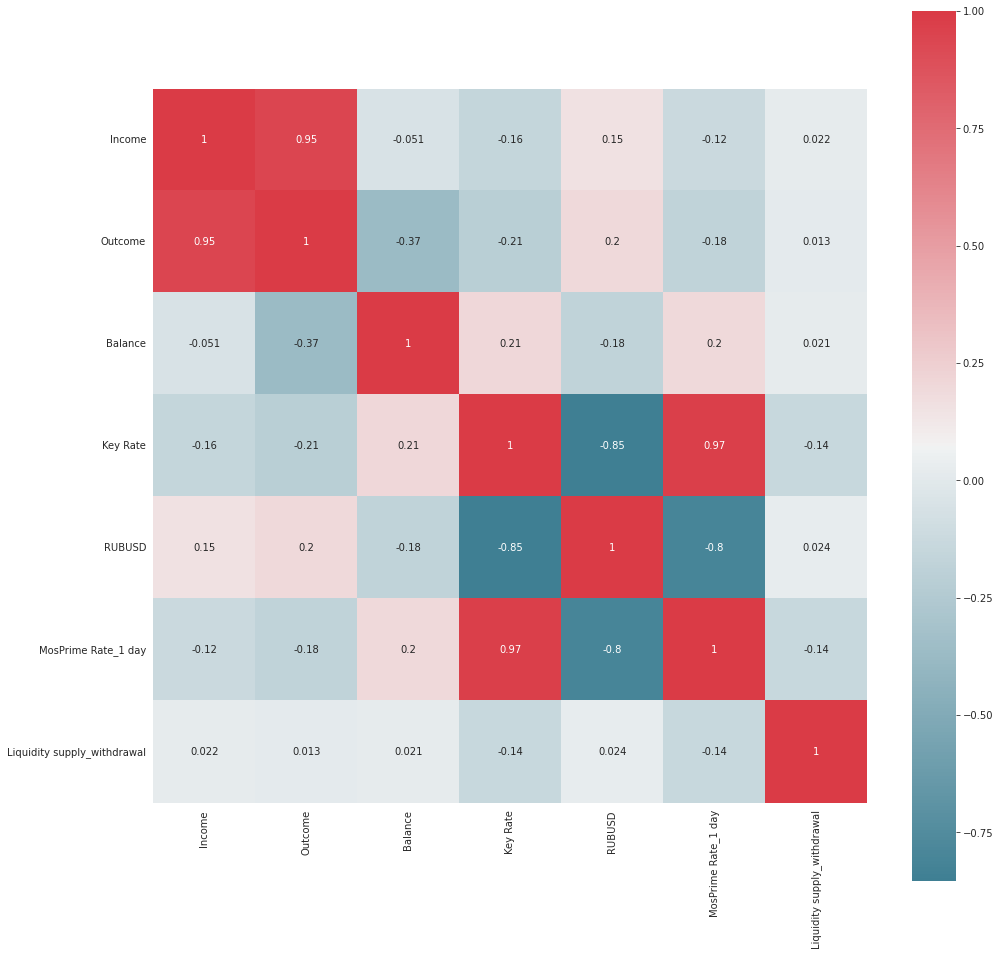

In [ ]:
macro_features = ['Key Rate', 'RUBUSD', 'MosPrime Rate_1 day', 'Liquidity supply_withdrawal']
corr_heatmap(df_full[cols[:3] + macro_features])

Key Rate тоже выкинем, т.к. он уже зашит в MosPrime и из-за этого у них крайне высокая корреляция между друг другом.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


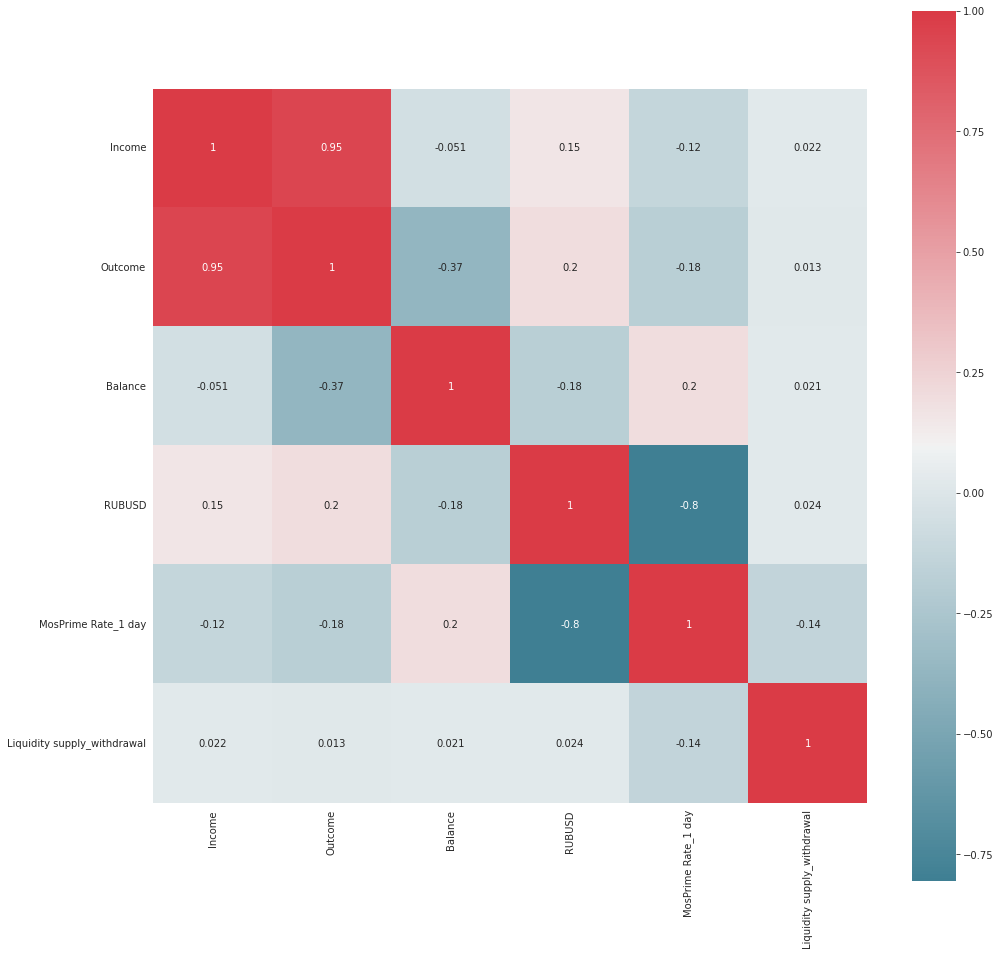

In [ ]:
macro_features = ['RUBUSD', 'MosPrime Rate_1 day', 'Liquidity supply_withdrawal']
corr_heatmap(df_full[cols[:3] + macro_features])

In [ ]:
df_full[macro_features].head()

,RUBUSD,MosPrime Rate_1 day,Liquidity supply_withdrawal
Date,,,
2017-01-09,NaN,0.1046,-460.10
2017-01-10,59.8961,0.1021,5.77
2017-01-11,59.9533,0.1023,551.30
2017-01-12,60.1614,0.1023,-330.40
2017-01-13,59.4978,0.1027,-310.80


Добавим их к нашим признакам

In [ ]:
df_macro = df_full[macro_features]
data = data.join(df_macro)
data = data.astype('float').fillna(method='ffill')
data = data[NUM_PREV_DAYS:]
data.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_26,lag_27,lag_28,workday,day,month,year,RUBUSD,MosPrime Rate_1 day,Liquidity supply_withdrawal
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-06,-0.032282,0.000000,0.000000,0.006791,0.083316,0.093309,-0.027000,-0.154703,0.000000,0.000000,...,0.007767,-0.125572,-0.155904,1.0,-0.228368,-0.058739,0.019244,58.912633,0.1020,175.40
2017-02-07,-0.041289,-0.032282,0.000000,0.000000,0.006791,0.083316,0.093309,-0.027000,-0.154703,0.000000,...,0.800391,0.007767,-0.125572,1.0,-0.061925,-0.058739,0.019244,58.712100,0.1003,199.10
2017-02-08,0.196944,-0.041289,-0.032282,0.000000,0.000000,0.006791,0.083316,0.093309,-0.027000,-0.154703,...,-0.019721,0.800391,0.007767,1.0,-0.046709,-0.058739,0.019244,59.193300,0.1032,-173.57
2017-02-09,0.434681,0.196944,-0.041289,-0.032282,0.000000,0.000000,0.006791,0.083316,0.093309,-0.027000,...,0.000000,-0.019721,0.800391,1.0,0.035342,-0.058739,0.019244,59.512900,0.1038,139.40
2017-02-10,0.183553,0.434681,0.196944,-0.041289,-0.032282,0.000000,0.000000,0.006791,0.083316,0.093309,...,0.000000,0.000000,-0.019721,1.0,-0.038566,-0.058739,0.019244,59.023500,0.1039,127.80


## Налоговые дни
В ходе проверки теории об использовании налоговых дней в качестве инструмента, помогающего получить более точный прогноз, я обнаружил, что в месяцы, когда необходимо платить аванс по налогу на прибыль на поквартальной основе (для налогоплательщиков, у которых за предыдущие четыре отчётных периода доходы от реализации не превышали в среднем 15 млн рублей за квартал), аномалии в потоках ДС сохраняются и после 28-го числа (платеж производятся не позднее 28 числа месяца, следующего за окончанием квартала). Продолжив изучать календарь бухгалтера, я пришел к выводу, что в данных присутствуют не только счета ЮЛ, но также счета ФЛ, дедлайн по налогам которых приходится на последний день месяца, следующего за кварталом, за который уплачивается НДФЛ.

# Feature selection

## Встроенные методы
Обучим линейную регрессию с разного рода регуляризациями и посмотрим на важность признаков

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_absolute_error

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

def plotModelResults(model, X_train=X_train, X_test=X_test, y_test=y_test, 
                     plot_intervals=False, plot_anomalies=False, 
                     train=False, error_function=mean_absolute_error):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    if train:
        prediction = model.predict(X_train)
        y_test = y_train
    else:
        prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0, alpha=0.5)
    
    if plot_intervals and not train:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = error_function(prediction, y_test).mean() 
    plt.title("Mean profit difference {0:.5f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plot_and_select(model, threshold=0.001):
    """
        Plots sorted coefficient values of the model and returns important features
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False)
    selected_features = list(coefs[coefs["abs"] > threshold].index)
    coefs.drop(["abs"], axis=1, inplace=True)
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()
    return selected_features

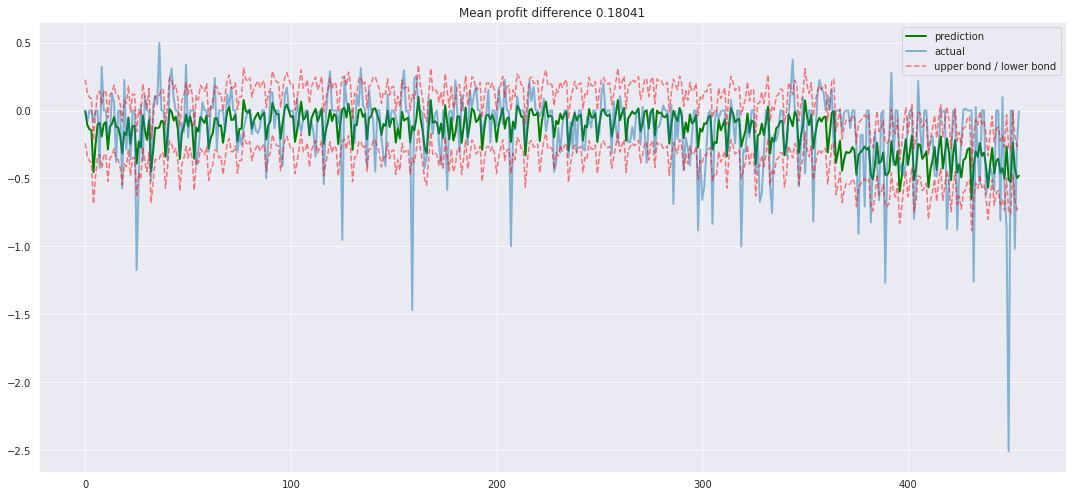

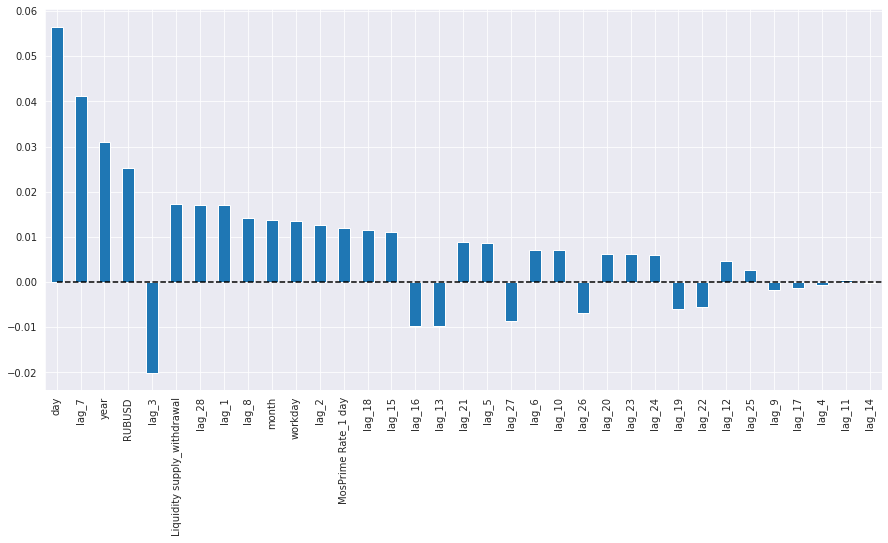

Ridge считает важными следующие признаки:
['day', 'lag_7', 'year', 'RUBUSD', 'lag_3', 'Liquidity supply_withdrawal', 'lag_28', 'lag_1', 'lag_8', 'month', 'workday', 'lag_2', 'MosPrime Rate_1 day', 'lag_18', 'lag_15']


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = RidgeCV()
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
selected_features_ridge = plot_and_select(ridge, threshold=0.01)
print("Ridge считает важными следующие признаки:")
print(selected_features_ridge)

Обучим Лассо, чтоб он нам автоматически занулил бесполезные признаки

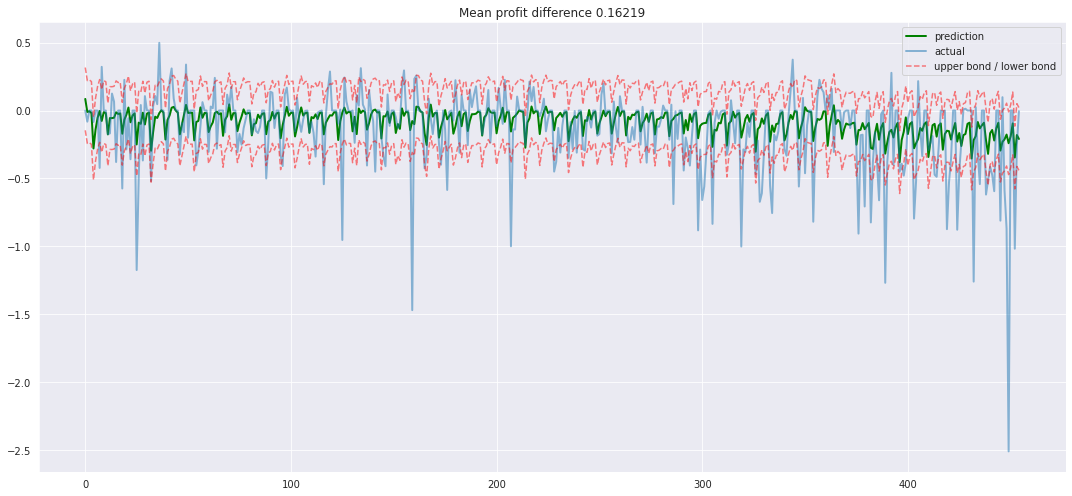

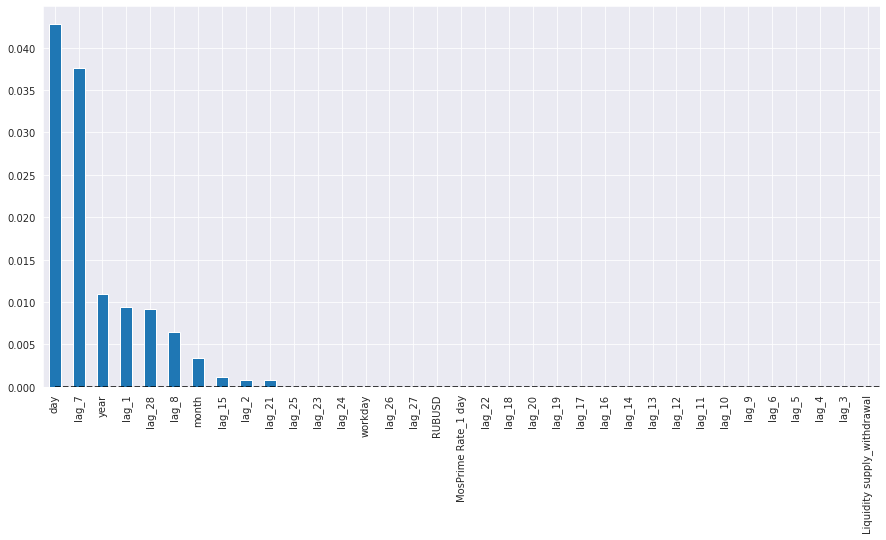

Lasso оставил следующие признаки:
['day', 'lag_7', 'year', 'lag_1', 'lag_28', 'lag_8', 'month', 'lag_15', 'lag_2', 'lag_21']


In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
selected_features_lasso = plot_and_select(lasso, 1e-6)
print("Lasso оставил следующие признаки:")
print(selected_features_lasso)

Лол.



К сожалению, макроэкономические признаки лассо посчитал бесполезными :(

![](https://i.ibb.co/MS3Vd04/photo-2022-05-21-19-54-32.jpg)


Но я не волк. Я соберу все результаты отбора фичей, а потом уже взвешу все "за" и "против". Обёрточные методы мне не пришлись по душе из-за своей вычислительной затратности и риска последующего переобучения. Потестим лучше
## Фильтрационные методы


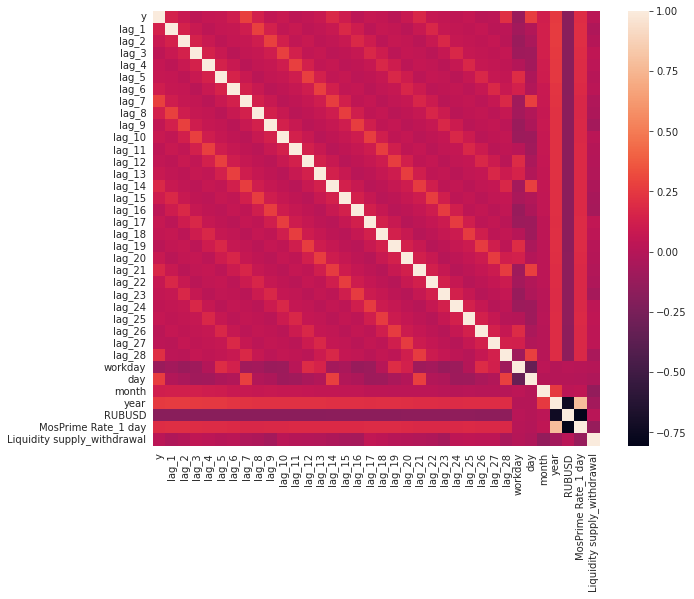

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr());

Выглядит не сильно плохо. Конечно, каждый лаг скоррелирован с предыдущим, да и макроэкономические коррелируют друг с другом (сильно) и с другими признаками (не так сильно). Посмотрим поближе с чем коррелирует баланс


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


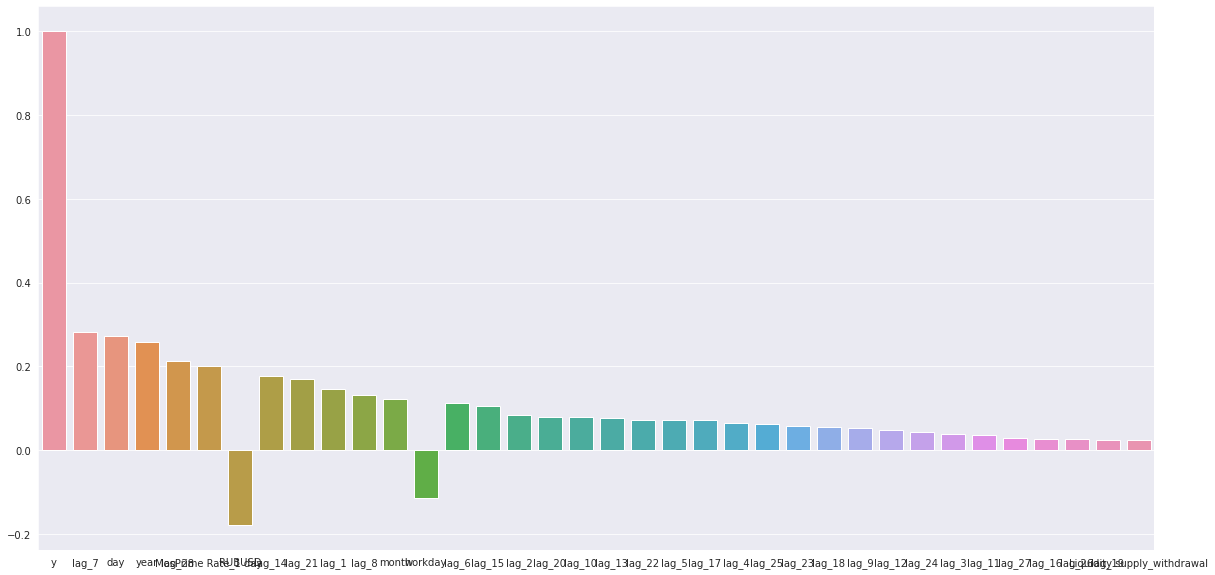

In [ ]:
y_corr = data.corr()['y'].sort_values(key=lambda x: -abs(x))
sns.barplot(y_corr.index, y_corr.values);

Отберём по порогу 0.08





In [ ]:
fltr_features = list(y_corr[np.abs(y_corr) > 0.08].index)
print(fltr_features)

['y', 'lag_7', 'day', 'year', 'lag_28', 'MosPrime Rate_1 day', 'RUBUSD', 'lag_14', 'lag_21', 'lag_1', 'lag_8', 'month', 'workday', 'lag_6', 'lag_15', 'lag_2']


И сразу же выкинем вдогонку признаки с маленькой дисперсией. Я передумал, так как у данных в принципе маленькая дисперсия

## Сравнение отборов признаков

In [ ]:
print(selected_features_ridge)
print(selected_features_lasso)
print(fltr_features)

['day', 'lag_7', 'year', 'RUBUSD', 'lag_3', 'Liquidity supply_withdrawal', 'lag_28', 'lag_1', 'lag_8', 'month', 'workday', 'lag_2', 'MosPrime Rate_1 day', 'lag_18', 'lag_15']
['day', 'lag_7', 'year', 'lag_1', 'lag_28', 'lag_8', 'month', 'lag_15', 'lag_2', 'lag_21']
['y', 'lag_7', 'day', 'year', 'lag_28', 'MosPrime Rate_1 day', 'RUBUSD', 'lag_14', 'lag_21', 'lag_1', 'lag_8', 'month', 'workday', 'lag_6', 'lag_15', 'lag_2']


Позже в пайплане будет релизован автоматический отбор признаков

# Prepocessing pipeline

Теперь соберём весь препроцессинг в один пайплайн

In [ ]:
from matplotlib import transforms
class FeatureBuilder():
    def __init__(self, selected_features=None, macro_data=df_macro, train=True):
        self.features = selected_features
        self.macro_data = macro_data
        self.train = train

    def fit(self, df, y=[]):
        self.df = df.copy()

        # categorical features
        self.df['workday'] = (df['Income'] != 0) & (df['Outcome'] != 0) & (~df.index.day_of_week.isin({5, 6}))
        self.df['day'] = df.index.day_name()
        self.df['month'] = df.index.month_name()
        self.df['year'] = df.index.year

        # encoding categorical features
        dicts = {}

        for c in ['day', 'month', 'year']:
            if self.features == None or c in self.features:
                dicts[c] = self.df.groupby(c)['Balance'].mean()

        self.dicts = dicts

        return self
        
    def transform(self, df, y=[]):

        start = df.index[0] - pd.Timedelta(days=NUM_PREV_DAYS)
        stop = df.index[0] - pd.Timedelta(days=1)
        res = self.df[start:stop].copy()
        res = res.append(df)
        if not self.train:
            res.loc[df.index[-1] + pd.Timedelta(days=1)] = [0] * res.shape[1]

        # categorical features
        res['workday'] = ~(res.index.isin(ru_holidays)) & ~(res.index.day_of_week.isin({5, 6}))
        res['day'] = res.index.day_name()
        res['month'] = res.index.month_name()
        res['year'] = res.index.year

        # encoding categorical features
        for c in ['day', 'month', 'year']:
            if self.features == None or c in self.features:
                res[c] = res[c].map(self.dicts[c])
        
        # lag features for Balance, Income and Outcome
        rolling_d = {'week' : 7, 'month' : 30, 'quarter' : 3 * 30, 'year': 365}

        for c in ['Balance', 'Income', 'Outcome']:
            for i in range(1, NUM_PREV_DAYS + 1):
                res[f"{c}_lag_{i}"] = res[c].shift(i)
            for name, days in rolling_d.items():
                res[f"{c}_rolling_{days}"] = res[c].shift(1).rolling(days).mean()


        res.astype('float')
        res = res.join(df_macro)
        res = res[NUM_PREV_DAYS:].fillna(method='ffill')
        res = res.fillna(method='bfill')
        y = y[NUM_PREV_DAYS:]
        if self.features != None:
            return res[self.features]
        return res.drop(['Balance', 'Income', 'Outcome'], axis=1)
        

In [ ]:
class MyScaler():
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, X, y=[]):
        self.scaler.fit(X)
        return self
    def transform(self, X, y=[]):
        cols = X.columns
        return pd.DataFrame(self.scaler.transform(X), columns=cols)

In [ ]:
class FeatureSelector():
    def __init__(self, kind='lasso', threshold=1e-6):
        """
        kind: 'ridge' or 'lasso'
        threshold: non-negative value to cut-off features with absolute value less than threshold
        """
        if kind == 'ridge':
            self.model = RidgeCV(cv=tscv)
        if kind == 'lasso':
            self.model = LassoCV(cv=tscv)
        # if kind == 'catboost':
        #     self.model = cb.CatBoostRegressor(loss_function='MAPE')
        # Решил в итоге не брать catboost, потому что долго обучает + непонятно по какому порогу отбирать фичи

        self.threshold = threshold
        
    def fit(self, X, y):
        self.model.fit(X, y)
        coefs = pd.DataFrame(self.model.coef_, X.columns)
        coefs.columns = ["coef"]
        coefs["abs"] = coefs.coef.apply(np.abs)
        coefs = coefs.sort_values(by="abs", ascending=False)
        self.features = list(coefs[coefs["abs"] > self.threshold].index)
        return self
    
    def transform(self, X, y=[]):
        return X[self.features]

        

In [ ]:
df_all = read_data(datafile)
train_idx = int(len(df_all) * 0.7)
df_train = df_all[:train_idx]
df_test = df_all[train_idx:]

fb = FeatureBuilder()
fb.fit(df_train)
fb.transform(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,workday,day,month,year,Balance_lag_1,Balance_lag_2,Balance_lag_3,Balance_lag_4,Balance_lag_5,Balance_lag_6,...,Outcome_lag_26,Outcome_lag_27,Outcome_lag_28,Outcome_rolling_7,Outcome_rolling_30,Outcome_rolling_90,Outcome_rolling_365,RUBUSD,MosPrime Rate_1 day,Liquidity supply_withdrawal
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-25,True,-0.016642,0.015900,-0.05184,0.995646,-0.080019,0.000000,0.000000,-0.248486,-0.043770,...,1.751,1.580,1.356,1.345000,1.250867,1.082500,1.195896,62.167300,0.0641,780.100000
2019-12-26,True,0.088986,0.015900,-0.05184,-0.146667,0.995646,-0.080019,0.000000,0.000000,-0.248486,...,0.000,1.751,1.580,1.431571,1.250867,1.082500,1.195896,61.716400,0.0640,203.400000
2019-12-27,True,0.004270,0.015900,-0.05184,0.636509,-0.146667,0.995646,-0.080019,0.000000,0.000000,...,0.000,0.000,1.751,1.521857,1.250867,1.082500,1.195896,61.767600,0.0643,197.800000
2019-12-28,False,-0.000052,0.015900,-0.05184,0.224004,0.636509,-0.146667,0.995646,-0.080019,0.000000,...,1.672,0.000,0.000,1.642286,1.296533,1.082500,1.195896,62.031500,0.0641,412.166667
2019-12-29,False,-0.000564,0.015900,-0.05184,0.102828,0.224004,0.636509,-0.146667,0.995646,-0.080019,...,1.330,1.672,0.000,1.642429,1.243900,1.082500,1.195896,61.989567,0.0639,626.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,False,-0.000052,0.001298,-0.05184,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,0.000000,...,2.976,0.000,0.000,2.223143,1.874067,1.655689,1.387784,75.757600,0.0467,-53.466667
2021-03-28,False,-0.000564,0.001298,-0.05184,0.000000,-2.510000,-0.869810,-0.587778,0.098041,-0.810884,...,2.370,2.976,0.000,2.223143,1.770500,1.655689,1.380641,75.781300,0.0466,-40.233333
2021-03-29,True,-0.159306,0.001298,-0.05184,0.000000,0.000000,-2.510000,-0.869810,-0.587778,0.098041,...,1.936,2.370,2.976,2.223143,1.671300,1.600100,1.380641,75.805000,0.0465,-27.000000


In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('feature_extraction', FeatureBuilder()), ('scaler', MyScaler()),
                ('feature selection', FeatureSelector(kind='lasso'))], verbose=True)


pipe.fit(df_train, df_train['Balance'][NUM_PREV_DAYS:])

X_train, y_train = pipe.transform(df_train),  df_train[['Balance', 'Income', 'Outcome']][NUM_PREV_DAYS:]
assert len(X_train) == len(y_train)
X_test, y_test = pipe.transform(df_test), df_test[['Balance', 'Income', 'Outcome']]
# assert len(X_test) == len(y_test)


[Pipeline]  (step 1 of 3) Processing feature_extraction, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] . (step 3 of 3) Processing feature selection, total=   1.6s


# Model


Реализуем несколько моделей и будем сравнивать их по следующим метрикам:
* Mean Absolute Error
* Max Absolute Error ($\le 0.42$ исходя из запроса заказчика)
* Real profit - Predicted profit (исходя из потребностей бизнеса)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error

def maxae(y_real, y_pred):
    return np.abs(y_real - y_pred).max()

rmse = lambda x, y: mean_squared_error(x, y, squared=False)

# Теперь реализуем бизнесовую метрику

real1, pred1 = -5, -3 # выгодней, потому что больше шанс заработать
real2, pred2 = -1, -3 

def cost(real, pred):
    diff = real - pred
    real_profit, pred_profit = real * (0.14 + 0.005), pred * (0.14 + 0.005)
    if diff < 0:
        pred_profit -= abs(diff) * (0.14 + 0.01)
    else:
        pred_profit += abs(diff) * (0.14 - 0.009)
    return real_profit - pred_profit 
cost_v = np.vectorize(cost)
cost_v(np.array([real1, real2]), np.array([pred1, pred2]))
profit_diff = lambda x, y: cost_v(x, y).mean()



### Линейная регрессия

In [ ]:
metrics = {'Max AE' : maxae, 'Profit difference' : profit_diff, 'MAE' : mae, 'MAPE' : mape, 'RMSE' : rmse}
res = pd.DataFrame(columns=['method'] + list(metrics.keys()))

def add_results(model, name, X, y):
    global res
    d = {'method' : name}
    y_pred, y_real = model.predict(X), y
    for k, f in metrics.items():
        d[k] = f(y_real, y_pred)
    res = res.append(d, ignore_index=True)
    plotModelResults(model, X_train, X, y)

def add_results_prediction(name, y_pred, y_real):
    global res
    d = {'method' : name}
    print(len(y_real), len(y_pred))
    for k, f in metrics.items():
        d[k] = f(y_real, y_pred)
    res = res.append(d, ignore_index=True)


463 463


,method,Max AE,Profit difference,MAE,MAPE,RMSE
0,Linear Regression diff,2.204282,0.001406,0.170309,6.993404e+13,0.262526


In [ ]:
# linear regression for income and outcome separately 
lr = LinearRegression()
lr.fit(X_train, y_train['Income'])
income = lr.predict(X_test)
lr.fit(X_train, y_train['Outcome'])
outcome = lr.predict(X_test)
y_pred = income - outcome
add_results_prediction(' Linear Regression diff', y_pred, y_test['Balance'])
res

,method,Max AE,Profit difference,MAE,MAPE,RMSE
0,Linear Regression diff,2.204282,0.001406,0.170309,6.993404e+13,0.262526
1,Linear Regression,2.203997,0.001404,0.170268,6.980010e+13,0.262551


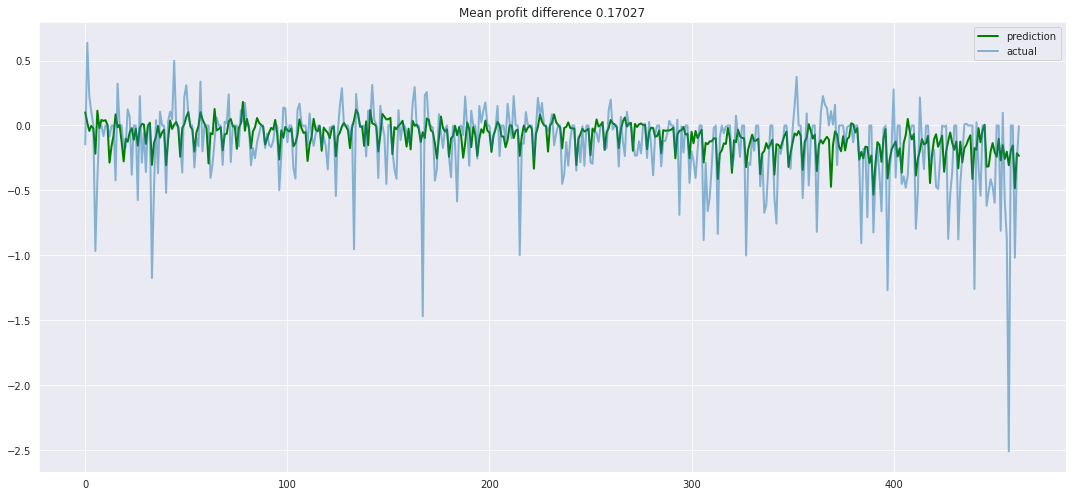

In [ ]:
# linear regression for Balance
lr = LinearRegression()
lr.fit(X_train, y_train['Balance'])
add_results(lr, 'Linear Regression', X_test, y_test['Balance'])
res

Линейная модель плохо предсказывает выбросы. В данных много выбросов, а линейная регрессия использует MSE в качестве Loss-функции. MSE чувствителен к выбросам, поэтому нужна либо линейная модель с другим лоссом, либо модель посложнее

[20:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,method,Max AE,Profit difference,MAE,MAPE,RMSE
0,Linear Regression diff,2.204282,0.001406,0.170309,6.993404e+13,0.262526
1,Linear Regression,2.203997,0.001404,0.170268,6.980010e+13,0.262551
2,XGBoost,2.238171,0.001401,0.168306,4.597416e+13,0.272578


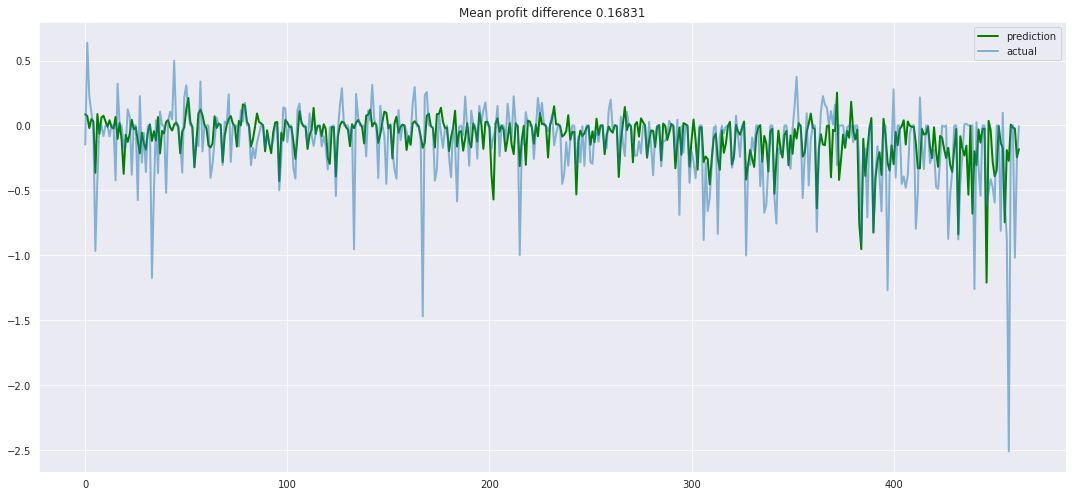

In [ ]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train['Balance'])
add_results(xgb, 'XGBoost', X_test, y_test['Balance'])
res

Пока эти методы показывают плохой перфоманс. К тому же для онлайн-обучения нужно будет каждый раз пересчитывать веса. Попробуем реализовать байесовский подход, плюс которого заключается в том, что всякий раз, когда к нам поступают новые данные, мы сможем обновлять веса за $O(1)$

### Попытка сделать байесовеский вывод
*(Failed)*

In [ ]:
from pybats.shared import load_sales_example
from pybats.analysis import *
from pybats.point_forecast import *
from pybats.plot import *

prior_length = NUM_PREV_DAYS   # Number of days of data used to set prior
k = 1               # Forecast horizon
rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
forecast_samps = len(X_test)  # Number of forecast samples to draw
forecast_start = y_test.index[0] # Date to start forecasting
forecast_end = y_test.index[-1] # + pd.Timedelta(days=1) # Date to stop forecasting
Y = df_all['Balance'].values
X = df_all[['Income', 'Outcome']].values

In [ ]:
seasPeriods=[7]
seasHarmComponents = [[1,2,3]]

mod, samples = analysis(Y, X,
                        k, forecast_start, forecast_end, nsamps=forecast_samps,
                        family='poisson',
                        seasPeriods=seasPeriods, 
                        seasHarmComponents=seasHarmComponents,
                        prior_length=prior_length, 
                        # holidays=ru_holidays,
                        dates=df_all.index,
                        rho=rho,
                        ret = ['model', 'forecast'])

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: overflow encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


beginning forecasting


/usr/local/lib/python3.7/dist-packages/pybats/shared.py:50: RuntimeWarning: overflow encountered in exp
  beta = np.exp(digamma(alpha) - ft)
/usr/local/lib/python3.7/dist-packages/pybats/dglm.py:474: RuntimeWarning: invalid value encountered in true_divide
  return np.random.negative_binomial(alpha, beta / (1 + beta), [nsamps])


ValueError: ignored

![](https://i.ibb.co/qp0QmPz/itsfucked.jpg)

### Catboost

MAPE в качестве лосса выбрано опытным путём. В сравнении с MAE (и, тем более, с RMSE), MAPE лучше всего оптимизирует бизнесовую метрику

,method,Max AE,Profit difference,MAE,MAPE,RMSE
0,Linear Regression diff,2.204282,0.001406,0.170309,6.993404e+13,0.262526
1,Linear Regression,2.203997,0.001404,0.170268,6.980010e+13,0.262551
2,XGBoost,2.238171,0.001401,0.168306,4.597416e+13,0.272578
3,CatBoost,2.084643,0.001420,0.161872,2.706032e+13,0.260109


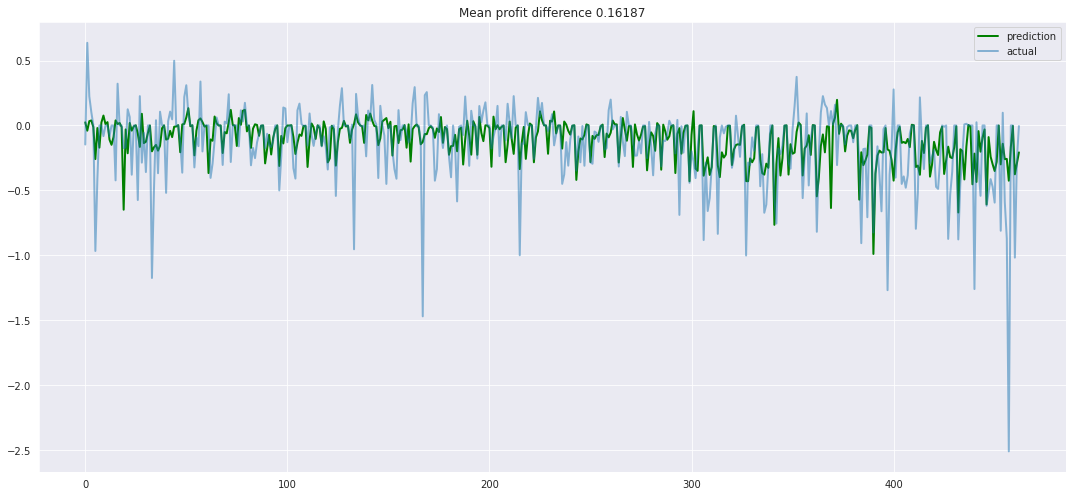

In [ ]:
ctbst = cb.CatBoostRegressor(loss_function='MAPE') 
ctbst.fit(X_train, y_train['Balance'], verbose=0)
add_results(ctbst, 'CatBoost', X_test, y_test['Balance'])
res


### ARIMA

In [ ]:
# seasonal_decompose(df['Balance'], 30)
# def plot_differenced_time_series(dfIndexed):
#     # Graph to identify order of differencing 
#     plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120}) 
    
#     #Original series 
#     fig , axes = plt.subplots(3, 2, sharex=True) 
#     axes[0, 0].plot(dfIndexed['Balance']); axes[0, 0].set_title('Original Series') 
#     plot_acf(dfIndexed['Balance'], ax=axes[0, 1]) 

#     # 1st Differencing 
#     axes[1, 0].plot(dfIndexed['Balance'].diff()); axes[1, 0].set_title('1st Order Differencing') 
#     plot_acf(dfIndexed['Balance'].diff().dropna(), ax=axes[1, 1]) 

#     # 2nd Differencing 
#     axes[2, 0].plot(dfIndexed['Balance'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing') 
#     plot_acf(dfIndexed['Balance'].diff().diff().dropna(), ax=axes[2, 1]) 

#     plt.show() 

# def augmented_dickey_fuller_test(df): 
#     X = df['Balance'].values 
#     result = adfuller(X)
#     print('ADF Statistic : %f' % result[0])
#     print (result[0], result[4]['5%'])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items(): 
#         print ('\t%s: %.3f' % (key, value)) 
#     if result[0] < result[4]['5%']: 
#         print ("Stationary")
#     else: 
#         print("Non-stationary")

# def cross_validation(df):
#     train_size = int(math.floor(df.shape[0] * 0.8))
#     balances_train = df[0:train_size]
#     balances_test = df[train_size:int(df.size)] 
#     return [balances_train, balances_test] 

# def run_ARIMA(trainingSet, testSet, p, d, q):
#     balances_model = ARIMA(trainingSet , order = (p, d, q))
#     balances_model_fit = balances_model.fit()
#     print(balances_model_fit.summary())
#     balances_model_forecast = balances_model_fit.forecast(steps = int(testSet.shape[0])) 
#     return balances_model_forecast 

# def determine_MSE_and_MAE(testSet, forecastedModel):
#     MSE = np.sqrt(mean_squared_error(testSet, forecastedModel)) 
#     MAE = mean_absolute_error(testSet, forecastedModel) 
#     return [MSE, MAE] 

### VAR

In [ ]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    X = list(series)
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
for c in y_train:
    check_stationarity(y_train[c])

ADF Statistic: -7.946996
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -5.074711
p-value: 0.000016
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -4.702340
p-value: 0.000083
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


Гипотеза о нестационарности Income, Outcome и Balance отклоняется в пользу альтернативы

In [ ]:
from statsmodels.tsa.api import VAR

for i in range(1, 12):
    model = VAR(y_train)
    results = model.fit(i)
    print(f'Order = {i}', )
    print(f'AIC: {results.aic}\n')

Order = 1
AIC: -14.337241515860663

Order = 2
AIC: -14.533963298267581

Order = 3
AIC: -14.561018454147177

Order = 4
AIC: -14.667950199210603

Order = 5
AIC: -14.710641724388449

Order = 6
AIC: -14.944306500361254

Order = 7
AIC: -15.245797673968829

Order = 8
AIC: -15.342748788629496

Order = 9
AIC: -15.347289705745775

Order = 10
AIC: -15.335287472668448

Order = 11
AIC: -15.325105110123639



AIC убывает до порядка 9, а потом снова начинает расти. То есть выбираем модель порядка 9

In [ ]:
result = model.fit(9)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, May, 2022
Time:                     20:35:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.9486
Nobs:                     1043.00    HQIC:                  -15.1961
Log likelihood:           3647.75    FPE:                2.16159e-07
AIC:                     -15.3473    Det(Omega_mle):     1.99645e-07
--------------------------------------------------------------------
Results for equation Balance
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.024572         0.038237            0.643           0.520
L1.Balance        -1.382454         2.348441           -0.589           0.556
L1.Income          1.444155         2.346014            0.616         

In [ ]:
y_tmp = y_train[-9:]
y_tmp = y_tmp.append(y_test)
pred = result.forecast(y_tmp.values, steps=1)

In [ ]:
pred

array([[-0.18086386,  2.54148002,  2.72380839]])

Не успел проверить результаты для этой модели.

# Выводы

Вообще говоря, линейная регрессия неплохо справляется с задачей. Единственное, надо получше поработать с отбором признаков. Например, сделать отдельный признак для выбросов и как-то их поизучать (понять, в какие даты сильно отрицательные и сильно положительные значения и поскать зависимости с теми же налоговыми днями)

In [ ]:
from bs4 import BeautifulSoup
import requests as rq

all_dates = []

for year in ['2017', '2018', '2019', '2020', '2021']:
    res = rq.get(f'https://www.garant.ru/calendar/nalog/federal/archive/{year}/')
    soup = BeautifulSoup(res.content, 'html.parser')
    all_dates.extend( [i.contents[0] for i in soup.find_all("strong", class_="lenta_calendar_data")] )
    
all_dates[:10]

[' 9 января 2017',
 '13 января 2017',
 '16 января 2017',
 '18 января 2017',
 '20 января 2017',
 '25 января 2017',
 '30 января 2017',
 '31 января 2017',
 ' 1 февраля 2017',
 '14 февраля 2017']

In [ ]:
all_dates

[' 9 января 2017',
 '13 января 2017',
 '16 января 2017',
 '18 января 2017',
 '20 января 2017',
 '25 января 2017',
 '30 января 2017',
 '31 января 2017',
 ' 1 февраля 2017',
 '14 февраля 2017',
 '15 февраля 2017',
 '20 февраля 2017',
 '27 февраля 2017',
 '28 февраля 2017',
 ' 1 марта 2017',
 '10 марта 2017',
 '15 марта 2017',
 '20 марта 2017',
 '27 марта 2017',
 '28 марта 2017',
 '30 марта 2017',
 '31 марта 2017',
 ' 3 апреля 2017',
 '14 апреля 2017',
 '17 апреля 2017',
 '18 апреля 2017',
 '20 апреля 2017',
 '25 апреля 2017',
 '28 апреля 2017',
 ' 2 мая 2017',
 '15 мая 2017',
 '17 мая 2017',
 '18 мая 2017',
 '22 мая 2017',
 '25 мая 2017',
 '29 мая 2017',
 '31 мая 2017',
 '15 июня 2017',
 '19 июня 2017',
 '20 июня 2017',
 '26 июня 2017',
 '28 июня 2017',
 '30 июня 2017',
 ' 3 июля 2017',
 '14 июля 2017',
 '17 июля 2017',
 '18 июля 2017',
 '20 июля 2017',
 '25 июля 2017',
 '28 июля 2017',
 '31 июля 2017',
 '14 августа 2017',
 '15 августа 2017',
 '18 августа 2017',
 '21 августа 2017',
 '25 

Попытались что-то придумать, но не вышло